In [77]:
import torch
from torch import nn

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv3d(3, 4, [3, 3, 3])
        self.bn1 = nn.BatchNorm3d(4, affine=False)
        self.relu = nn.ReLU()
    
    def forward(self, X):
        return self.relu(self.bn1(self.conv1(X)))
    
net = Net()

activations = {}
def hook(name):
    def hook_fn(m, i, o):
        activations[name] = o
    return hook_fn

net.conv1.register_forward_hook(hook('conv1'))
net.bn1.register_forward_hook(hook('bn1'))

opt = torch.optim.Adam(net.parameters(), lr=.01)

# Use a ramp-up for sensitive components like BN.
def ramp_up_one(epoch): 
    alpha = min(max(epoch - 50, 0.0) / 50, 1.0)
    return alpha

#scheduler = torch.optim.lr_scheduler.LambdaLR(opt, [ramp_up_one])

m1 = []
s1 = []

m2 = []
s2 = []

m3 = []
s3 = []
#net.eval()

for i in range(100):
    net.zero_grad()
    X, Y = torch.randn(10, 3, 7, 7, 7), torch.randn(10, 4, 5, 5, 5)
    Yp = net(X)
    loss = ((Y - Yp) ** 2).mean()
    loss.backward()
    opt.step()
    
    m1.append(activations['conv1'].mean().item())
    s1.append(activations['conv1'].permute(1, 0, 2, 3, 4).reshape(4, -1).std(axis=1).mean().item())
    m2.append(activations['bn1'].mean().item())
    s2.append(activations['bn1'].permute(1, 0, 2, 3, 4).reshape(4, -1).std(axis=1).mean().item())
    #m3.append(net.bn1.bias.mean().item())
    #s3.append(net.bn1.weight.mean().item())

    #scheduler.step()

print([np.mean(m1), np.mean(m2), np.mean(s1), np.mean(s2)])

[-0.03467304876307026, 3.733635024760762e-10, 0.8834849941730499, 1.0003932809829712]


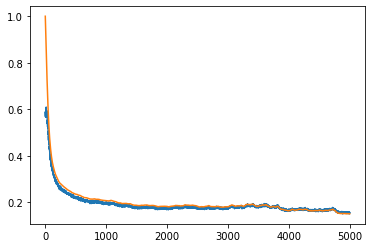

In [73]:
import matplotlib.pyplot as plt
import numpy as np

plt.plot(np.array(s1) * np.array(s3))
plt.plot(np.array(s2))

In [62]:
plt.plot(np.array(s1) * np.array(s3))
plt.plot(np.array(s2))

Parameter containing:
tensor([-0.6501, -0.6477, -0.6504, -0.6407], requires_grad=True)